In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, shutil
from pathlib import Path
import math
import scipy
from math import sqrt, log, pi, exp, sinh
from scipy.optimize import curve_fit, leastsq
import matplotlib.gridspec as gridspec
from scipy.signal import argrelextrema
from scipy.interpolate import UnivariateSpline
from scipy.signal import lfilter
from scipy.signal import savgol_filter
import os.path
from os import path

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 8.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir
    
print(workdir)

/Users/coralie/Desktop/mikael/temp


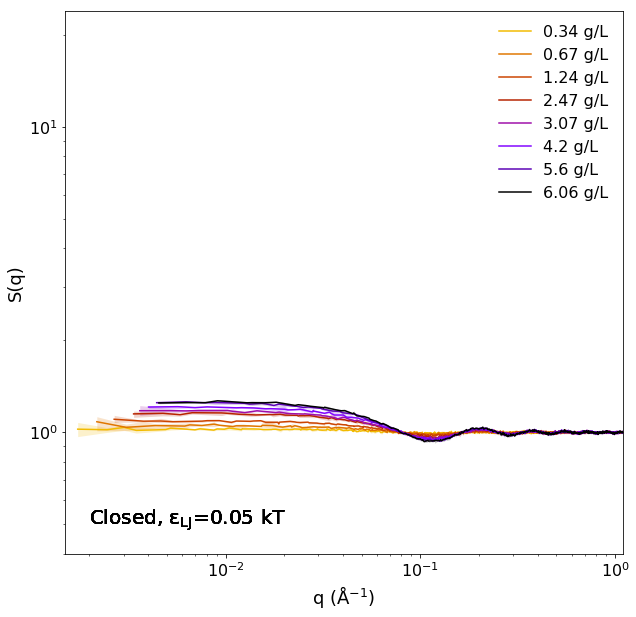

In [8]:
%cd -q $workdir

serie = "series2"
conf = "open"
epslj = 0.005
epshh = 0.485

for C in [0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06]:
    if C == 0.34:
        col = '#f2bb00'
    elif C == 0.67:
        col = '#e07600'
    elif C == 1.24:
        col = '#cc4400'
    elif C == 2.47:
        col = '#b72300'
    elif C == 3.07:
        col = '#9e0ea9'
    elif C == 4.2:
        col = '#8104ff'
    elif C == 5.6:
        col = '#5a01b5'
    elif C == 6.06:
        col='black'

    nriter = 0
    smoy = [0] * 600
    qmoy = [0] * 600
    smax = [0] * 600
    smin = [1000] * 600
    for dp in [0,1,2]:
        pfx = str(serie)+"-"+str(conf)+"-h"+str(epshh)+"-e"+str(epslj)+"-C"+str(C)+"-dp"+str(dp)
        %cd -q $pfx
        if path.exists("debye_n2.dat"):
            q,s = np.loadtxt("debye_n2.dat", unpack=True)
            nriter = nriter + 1   
            for i in np.arange(0,len(q),1):
                qmoy[i] = q[i]
                smoy[i] = smoy[i] + s[i]
                if smax[i] < s[i]:
                    smax[i] = s[i]
                if smin[i] > s[i]:
                    smin[i] = s[i]                    
        else:
            print("nope! for", pfx)
        %cd -q '..' 
 
    for i in np.arange(0,len(q),1):
        smoy[i] = smoy[i]/nriter

    plt.plot(qmoy,smoy,color=col,label=str(C)+" g/L")
    plt.fill_between(qmoy,smin,smax,interpolate=True, color=col, alpha=0.2, lw=0)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(0.4,24)
    plt.xlim(0.0015,1.1)
    plt.xlabel("q ("r'${\rm{\AA}^{-1}}$'")", fontsize=18)
    plt.ylabel("S(q)", fontsize=18)
    plt.text(0.002, 0.5, "Closed, "r'${\rm{\varepsilon_{LJ}}}$'"=0.05 kT", fontsize=20)
    plt.legend(frameon=False, loc=1)
    np.savetxt(str(serie)+"-"+str(conf)+"-h"+str(epshh)+"-e"+str(epslj)+"-C"+str(C)+'_moy.dat',np.transpose((qmoy,smoy)))
    #plt.savefig("sq_tll_open_0-005.pdf", bbox_inches='tight')

%cd -q $workdir

## Regression on low-q part of S(q)

S(0) = 1.1194346779842528


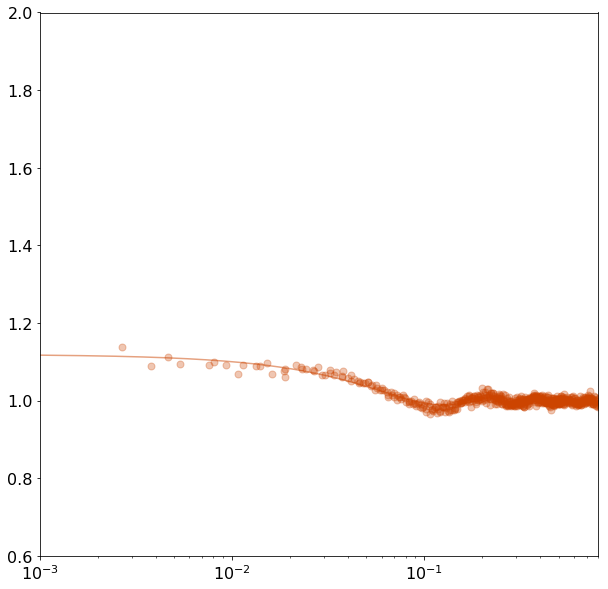

In [27]:
%cd -q $workdir
from scipy import stats
plt.rcParams.update({'font.size': 16, 'figure.figsize': [10.0, 10.0]})

serie = "series2"
conf = "open"
epslj = 0.005
epshh = 0.485

fit = "spline"

for C in [1.24]: #[0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06]:
    if C == 0.34:
        col = '#f2bb00'
    elif C == 0.67:
        col = '#e07600'
    elif C == 1.24:
        col = '#cc4400'
    elif C == 2.47:
        col = '#b72300'
    elif C == 3.07:
        col = '#9e0ea9'
    elif C == 4.2:
        col = '#8104ff'
    elif C == 5.6:
        col = '#5a01b5'
    elif C == 6.06:
        col='black'


    limmin = 0.0
    limmax = 1.0 #0.0518 #0.0897

    for dp in [2]: #[0,1,2]:
        q_range = []
        s_range = []
        interceptlist = []
        conclist = []
        invs0list = []
        pfx = str(serie)+"-"+str(conf)+"-h"+str(epshh)+"-e"+str(epslj)+"-C"+str(C)+"-dp"+str(dp)
        %cd -q $pfx
        if path.exists("debye_n2.dat"):
            q,s = np.loadtxt("debye_n2.dat", unpack=True)
            for i in np.arange(0,len(q)):
                    if q[i] > limmin and q[i] < limmax:
                        q_range.append(q[i])
                        s_range.append(s[i])
                 
            if fit == "optim":
                typ = "2exp"               
                if typ == "exp":
                    def _exp(x,A,B,C,offset):
                        return A*np.exp(B*x**C) + offset
                    A_g = 1
                    B_g = 1
                    C_g = 1
                    offset_g = 1
                    function = _exp
                    initialParameters = np.array([A_g,B_g,C_g,offset_g])
                    param_names = ["A","B","C","offset"]
                
                elif typ == "2exp":
                    def _2exp(x,A,B,C,D,E,F,offset):
                        return A*np.exp(B*x**C) + D*np.exp(E*x**F) + offset
                    A_g = 1
                    B_g = -1000
                    C_g = 1
                    D_g = 1
                    E_g = -1000
                    F_g = 1
                    offset_g = 1
                    function = _2exp
                    initialParameters = np.array([A_g,B_g,C_g,D_g,E_g,F_g,offset_g])
                    param_names = ["A","B","C","D","E","F","offset"]
                    
                elif typ == "3exp":
                    def _3exp(x,A,B,C,D,E,F,G,H,I,offset):
                        return A*np.exp(B*x**C) + D*np.exp(E*x**F) + G*np.exp(H*x**I) + offset
                    A_g = 1
                    B_g = -1000
                    C_g = 1
                    D_g = 1
                    E_g = -1000
                    F_g = 1
                    G_g = 1
                    H_g = -1
                    I_g = 1
                    offset_g = 1
                    function = _3exp
                    initialParameters = np.array([A_g,B_g,C_g,D_g,E_g,F_g,G_g,H_g,I_g,offset_g])
                    param_names = ["A","B","C","D","E","F","G","H","I","offset"]
         
                xdata = np.array(q_range)
                ydata = np.array(s_range)
                output_param, pcov = curve_fit(function, xdata, ydata, initialParameters)

                fit = function(xdata, *output_param)

                abserror = fit - ydata

                sumsquares_res = np.sum(abserror**2)
                sumsquares_tot = np.sum((ydata-np.mean(ydata))**2)
                r2 = 1 - (sumsquares_res / sumsquares_tot)

                print("Rsqr =", r2)
                print("Sum of squares =", sumsquares_res)
                print("")
              
                if typ=="exp":
                    A = output_param[0]
                    B = output_param[1]
                    C2 = output_param[2]
                    offset = output_param[3]
                    r = np.linspace(0.001,limmax,1000)
                    plt.plot(r,_exp(r,A,B,C2,offset),color=col)
                    print("S(0) =", _exp(0,A,B,C2,offset))
                
                elif typ=="2exp":
                    A = output_param[0]
                    B = output_param[1]
                    C2 = output_param[2]
                    D = output_param[3]
                    E = output_param[4]
                    F = output_param[5]
                    offset = output_param[6]
                    r = np.linspace(0.001,limmax, 1000)
                    print("S(0) =", _2exp(0,A,B,C2,D,E,F,offset))
                    plt.plot(r,_2exp(r,A,B,C2,D,E,F,offset),color=col)    
                    
                elif typ=="3exp":
                    A = output_param[0]
                    B = output_param[1]
                    C2 = output_param[2]
                    D = output_param[3]
                    E = output_param[4]
                    F = output_param[5]
                    G = output_param[6]
                    H = output_param[7]
                    I = output_param[8]
                    offset = output_param[9]
                    r = np.linspace(0.001,limmax, 1000)
                    print("S(0) =", _3exp(0,A,B,C2,D,E,F,G,H,I,offset))
                    plt.plot(r,_3exp(r,A,B,C2,D,E,F,G,H,I,offset),color=col)             
                        
                                      
            elif fit == "polyf":
                a = np.polyfit(q_array, s_array, 1)
                plt.plot(q_array, a[0]*q_array + a[1])
                
            elif fit == "savgol":
                q_array = np.array(q_range)
                s_array = np.array(s_range)
                sdata = savgol_filter(s_array, 11, 2)
                dev = sdata - s_array
                plt.plot(q_array, sdata, color=col)
                
            elif fit == "spline":
                spl = UnivariateSpline(np.array(q_range), np.array(s_range))

                spl.set_smoothing_factor(0.05)
                r = np.linspace(0.001,0.2, 10000)
                plt.plot(r, spl(r), alpha=0.5, color=col)
                print("S(0) =", spl(0))
             
            plt.plot(q, s, ms=7, marker='o',ls='None', color=col, alpha=0.3, label=str(C)+" g/L")
            plt.xlim(0.001,0.8)
            plt.ylim(0.6,2.0)
            plt.xscale('log')
            #plt.yscale('log')
            #plt.plot(q_range, s_range, ms=7, marker='o',ls='None', color=col, label=str(C)+" g/L")
                             
            %cd -q '..'

        else:
            print("nope! for", pfx)
            %cd -q '..' 


## Make I(q) from simulation

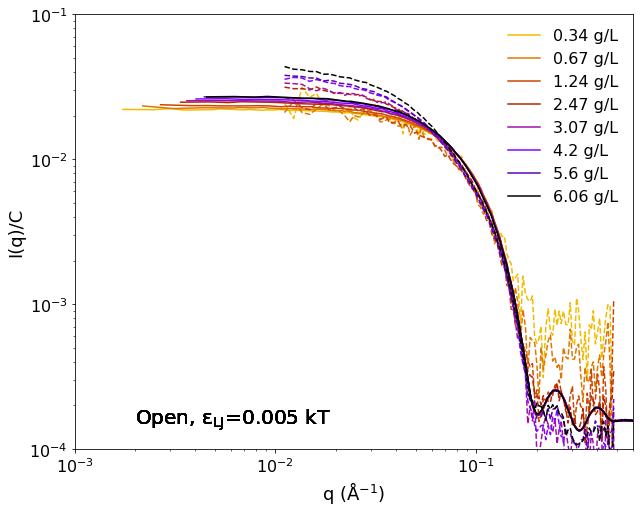

In [31]:
%cd -q $workdir
plt.rcParams.update({'font.size': 16, 'figure.figsize': [10.0, 8.0]})

serie = "series2"
conf = "open"
epslj = 0.005
epshh = 0.485

qmon, imon = np.loadtxt("formf_s2_closed.dat", usecols=(0,1), unpack=True)

for C in [0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06]:
    if C == 0.34:
        col = '#f2bb00'
        eq, ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02928_H2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)
    elif C == 0.67:
        col = '#e07600'
        eq,ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02925_G2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)
    elif C == 1.24:
        col = '#cc4400'
        eq,ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02923_F2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)
    elif C == 2.47:
        col = '#b72300'
        eq,ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02916_E2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)
    elif C == 3.07:
        col = '#9e0ea9'
        eq,ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02914_D2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)
    elif C == 4.2:
        col = '#8104ff'
        eq,ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02911_C2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)
    elif C == 5.6:
        col = '#5a01b5'
        eq,ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02909_B2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)
    elif C == 6.06:
        col='black'
        eq,ei = np.loadtxt('./exp_data/2-nospirr_noglyc/RBS_A_02906_A2-T1_lipase_s2_000_c.dat', unpack=True, usecols=(0,1),skiprows=3)

    qy,sy = np.loadtxt(str(serie)+"-"+str(conf)+"-h"+str(epshh)+"-e"+str(epslj)+"-C"+str(C)+'_moy.dat',unpack=True)
    formf = np.interp(qy,qmon,imon)
    plt.plot(qy,sy*formf,color=col,label=str(C)+" g/L")
    plt.plot(eq,ei/C,color=col,ls='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-4,1e-1)
    plt.xlim(1e-3,6e-1)
    plt.xlabel("q ("r'${\rm{\AA}^{-1}}$'")", fontsize=18)
    plt.ylabel("I(q)/C", fontsize=18)
    plt.text(0.002, 1.5e-4, "Open, "r'${\rm{\varepsilon_{LJ}}}$'"=0.005 kT", fontsize=20)
    plt.legend(frameon=False, loc=1)
    plt.savefig("Iq_tll_open_0-005.pdf", bbox_inches='tight')

## Plot B2 from manybody

In [ ]:
from scipy import stats

%cd -q $workdir


series = "series2"
structure = "open"
epsHH_kT = 0.485
eps_kT = 0.005
mod = 0


if series=="series1_R20":
    Mw = 31598.27
    expe = -4.034
    expdata = "s0_exp_series1.dat"
elif series=="series2":
    Mw = 29609.61
    expe = -5.42
    expdata = "s0_exp_series2.dat"

    
cnctr,intrc = np.loadtxt(str(series)+'-'+str(structure)+'-h'+str(epsHH_kT)+'-e'+str(eps_kT)+'-dp'+str(mod)+'_intercepts.dat', usecols=(0,1),unpack=True)
conc_s0, invs0_exp, s0_exp = np.loadtxt(expdata, usecols=(0,1,2),unpack=True)

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(cnctr,intrc)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(conc_s0,invs0_exp)

plt.plot(cnctr,intrc,'ro', ms=8,label="Many-body simulations")
plt.plot(cnctr,cnctr*slope1+intercept1,'r-',lw=1.5)
#plt.title("TLLm, open, "+r"$\varepsilon_{LJ} = 0.005 kT$"+", "+r"$\varepsilon_{H-H} = 0.485 kT$",size=20,y=1.02)
plt.plot(conc_s0,invs0_exp,'bo', ms=8,label="Experiments")
plt.plot(conc_s0,conc_s0*slope2+intercept2,'b-',lw=1.5)

plt.xlabel("$c_p$ (g/L)", size=20)
plt.ylabel("$1/S(0)$", size=20)
plt.legend(frameon=False, fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(str(title)+", "+r"$\varepsilon_{H-H}$ = "+str(epsHH_kT)+" $kT$, "+r"$\varepsilon_{LJ}$ = "+str(eps_kT)+" $kT$")

N_A = 6.02214129*1e+23

A2 = slope1/(2*Mw)
B2_raw = A2 * Mw**2 / N_A
B2_HS = 2 * math.pi * (27.8*(10**-9)*2)**3 / 3
B2_norm = B2_raw / B2_HS

A2_exp = slope2/(2*Mw)
B2_raw_exp = A2_exp * Mw**2 / N_A
B2_HS_exp = 2 * math.pi * (27.8*(10**-9)*2)**3 / 3
B2_norm_exp = B2_raw_exp / B2_HS_exp

print("inferior to 1?", 2*Mw*A2)
print("slope =", slope1)
print("A2 =", A2)
print("B2 raw =", B2_raw)
print("B2 HS =", B2_HS)
print("-----------------------------------")
print("B2 norm. =", B2_norm)

#print("B2 exp. is :", expe)
print("B2 exp.2 is :", B2_norm_exp)


#plt.savefig('b2fromsq-'+str(series)+'-'+str(structure)+'-h'+str(epsHH_kT)+'-e'+str(eps_kT)+'.pdf', bbox_inches='tight')

%cd -q $workdir

## Colormap

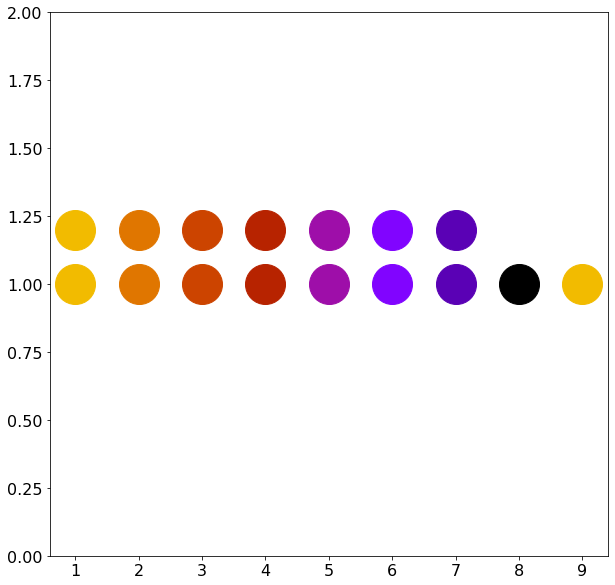

In [22]:
from cycler import cycler
plt.rcParams.update({'font.size': 16, 'figure.figsize': [10.0, 10.0]})
colormap = plt.cm.gnuplot_r
plt.gca().set_prop_cycle('color', plt.cm.gnuplot_r(np.linspace(0.1,1,8)))

a = [1,2,3,4,5,6,7,8]
b = [1]

for i in a:
    for j in b:
        plt.plot(i,j,ls='None',marker='o',ms=40)
        plt.ylim(0,2)
        
plt.plot(1,1.2,color = '#f2bb00',ls='None',marker='o',ms=40)
plt.plot(2,1.2,color = '#e07600',ls='None',marker='o',ms=40)
plt.plot(3,1.2,color = '#cc4400',ls='None',marker='o',ms=40)
plt.plot(4,1.2,color = '#b72300',ls='None',marker='o',ms=40)
plt.plot(5,1.2,color = '#9e0ea9',ls='None',marker='o',ms=40)
plt.plot(6,1.2,color = '#8104ff',ls='None',marker='o',ms=40)
plt.plot(7,1.2,color = '#5a01b5',ls='None',marker='o',ms=40)
        